In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [3]:
%pip install -qU torch transformers sentence-transformers polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 51.0 MB/s eta 0:00:00


# Imports

In [4]:
import json
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor
from tqdm import tqdm, trange
from transformers import AutoTokenizer, AutoModel

import polars as pl
import pickle
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Load summaries

In [5]:
!unzip -q /content/drive/MyDrive/legal_ai/practices_db/data/summaries.zip

In [6]:
summaries_path = Path("/content/summaries")
summaries_paths = list(summaries_path.iterdir())
len(summaries_paths)

18052

In [7]:
summaries = {}
for summary_path in tqdm(summaries_paths):
    with open(summary_path, "r") as f:
        summaries[summary_path.stem] = f.read()

100%|██████████| 18052/18052 [00:01<00:00, 11243.24it/s]


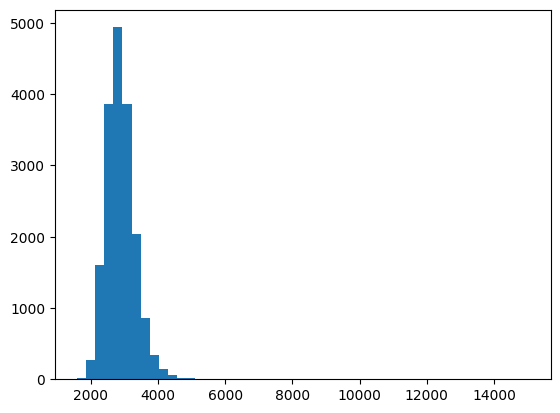

In [8]:
plt.hist([len(s) for s in summaries.values()], bins=50);

In [9]:
pl.Series([len(s) for s in summaries.values()]).describe()

statistic,value
str,f64
"""count""",18052.0
"""null_count""",0.0
"""mean""",2885.61899
"""std""",435.447693
"""min""",1597.0
"""25%""",2598.0
"""50%""",2847.0
"""75%""",3123.0
"""max""",15021.0


# Calculate embeddings

We need to calculate embeddings beforehand and save them in order to not re-calculate

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [12]:
model_name = 'deepvk/USER-bge-m3'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.33M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/697 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

In [13]:
def process_in_batches(model, tokenizer, input_texts, batch_size=16, device=torch.device("cpu")):
    embeddings = []
    for i in trange(0, len(input_texts), batch_size):
        batch_texts = input_texts[i:i + batch_size]

        batch_dict = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

        with torch.no_grad():
            outputs = model(**batch_dict)
            batch_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

        batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
        embeddings.append(batch_embeddings.cpu())

        del batch_dict, outputs, batch_embeddings
        torch.cuda.empty_cache()


    return torch.cat(embeddings, dim=0)

In [14]:
%%time
embeddings = process_in_batches(model, tokenizer, list(summaries.values()), batch_size=16, device=device)
embeddings.shape

100%|██████████| 1129/1129 [59:07<00:00,  3.14s/it]

CPU times: user 58min 13s, sys: 24 s, total: 58min 37s
Wall time: 59min 7s


torch.Size([18052, 1024])

In [15]:
# Save embeddings and uids
np.save("/content/drive/MyDrive/legal_ai/practices_db/data/summaries_emb.npy", embeddings)

with open("/content/drive/MyDrive/legal_ai/practices_db/data/summaries_emb_uids.pkl", "wb") as f:
    pickle.dump(list(summaries.keys()), f)

In [16]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1377 MiB |  10803 MiB |  30570 GiB |  30569 GiB |
|       from large pool |   1376 MiB |  10800 MiB |  30403 GiB |  30401 GiB |
|       from small pool |      1 MiB |      5 MiB |    167 GiB |    167 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1377 MiB |  10803 MiB |  30570 GiB |  30569 GiB |
|       from large pool |   1376 MiB |  10800 MiB |  30403 GiB |